# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

Found 2 images


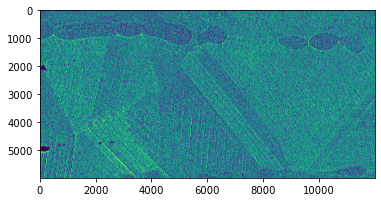

In [1]:
# preamble

import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os

# folder path

folder_path=Path(r'C:\Alex\crosspy\data\Ben')
Images = Imset(folder_path,'tif')

plt.imshow(Images.imload([1]))




2

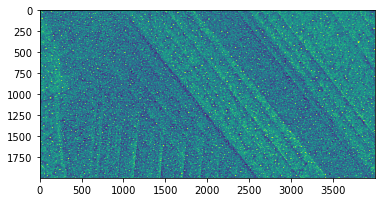

In [2]:
# Image crop

import cv2
img = Images.imload([0,1])
y = 2000
h = 2000
x = 4000
w = 4000
Images = img[y:y+h, x:x+w, :]
plt.imshow(Images[:,:,1])
Images.shape[2]



In [ ]:
# first pass settings

filter_settings=[4,2,15,8]
roi_1stpass = dict(size_pass = 500, overlap_percentage = 70, xcf_mesh=600)

# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)
%timeit dic_1stpass.run_sequential()

Running sequential DIC on image pair 1 of 1 ...


C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:185: RuntimeWarning: invalid value encountered in multiply
  kern = ROI_ref*ne.evaluate('exp(ROI_test)')
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:186: RuntimeWarning: invalid value encountered in matmul
  arg3=kernr@kern@kernc
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:185: RuntimeWarning: overflow encountered in multiply
  kern = ROI_ref*ne.evaluate('exp(ROI_test)')
C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\crosspy\XCF.py:186: RuntimeWarning: overflow encountered in matmul
  arg3=kernr@kern@kernc


... Completed in (s) 2306.7788214683533
Running sequential DIC on image pair 1 of 1 ...


In [ ]:
dic_1stpass.plot_displacements()


In [ ]:
# Fast image transform and interpolation
import cv2
import numpy as np
from scipy.optimize import least_squares
from scipy import interpolate
import time
start_time = time.time()

def im_correct(Images,d, method='map_opencv'):

    # Function to translate and rotate images to correct for 
    # rigid body rotation and translation

    shift_x=d.dx_maps
    shift_y=d.dy_maps
    pos_x=d.x_pos
    pos_y=d.y_pos

    # Load the first image and generate pixel arrays
    if type(Images) is np.ndarray:
        image_ref = Images[:,:,0]
        images = Images
    else:
        image_ref = Images.imload([0])
        images = Images.imload([])
    x, y = np.meshgrid(range(0,np.size(image_ref,1)),range(0,np.size(image_ref,0)))
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    image_c = np.zeros(images.shape)
    image_c[:,:,0] = image_ref

    for i in range(0,images.shape[2]-1):
        # load second image and the shifts of a XCF pass
        
        im = images[:,:,i+1]
        x_shifts = shift_x[:, :, i]
        y_shifts = shift_y[:, :, i]
        
        # Correct rigid translation in x and y 
        # by subtracting the mean shift to every coordinate
        x_shifts_new = (x_shifts - np.mean(x_shifts)).flatten('F')
        y_shifts_new = (y_shifts - np.mean(y_shifts)).flatten('F')

        ## Guess rotation scheme
        # - rotation is confined between 90 degrees 
        # - with moving rotation axis
        params0 = np.array([np.size(im,1)/8, np.size(im,0)/1, -2.]) #initial [x_centre, y_centre, theta]
        ub = np.array([np.size(im,1), np.size(im,0), 45]) #upper bound [x_centre, y_centre, theta]
        lb = np.array([1, 1, -45]) #lower bound [x_centre, y_centre, theta]

        # A least squares regression scheme is utilised to approximate the 
        # centre of rotation and rotation angle
        l2_fit = rot_calc(x_shifts_new, y_shifts_new, pos_x, pos_y, params0, ub, lb)
        params1 = l2_fit.x
        
        # correct image rotation
        xc = params1[0] # Centre x
        yc = params1[1] # Centre y
        theta = params1[2] * np.pi/180 # Rotation theta
        rotation = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        # Apply corrections by creating the an array containing the
        # corrected coordinates and then mapping those coordinates
        # to existing pixel grid
        
        if method == 'map_scipy':
            # This method is quite slow
            im_shifts = np.column_stack((x.flatten('F')-np.mean(x_shifts), y.flatten('F')-np.mean(y_shifts)))
            im_rot = np.dot(np.column_stack((im_shifts[:,0]-xc,im_shifts[:,1]-yc)),rotation)
            im_correct = np.column_stack((im_rot[:,[0]]+xc, im_rot[:,[1]]+yc))
            points_corr = [(row[0],row[1]) for row in im_correct]
            #Below interpolates corrected values on grid following surface f(x,y) = z
            image_c[:,:,i+1] = interpolate.griddata(points=points_corr, values=im.flatten('F'), xi=(x,y), method='linear')
            
        elif method == 'map_opencv':
            # This method uses opencv remap - very fast
            x_cor, y_cor = x-np.mean(x_shifts), y-np.mean(y_shifts) #shifts
            points_cor = np.einsum('ji, mni -> jmn', rotation, np.dstack([x-xc, y-yc]))
            x_map = points_cor[0,:,:]+xc
            y_map = points_cor[1,:,:]+yc
            x_map = x_map.astype(np.float32)
            y_map = y_map.astype(np.float32)
            image_c[:,:,i+1] = cv2.remap(src=im, map1=x_map, map2=y_map, interpolation=cv2.INTER_CUBIC)
            
        elif method == 'affine':
            rows,cols = im.shape
            # Translation
            x_shift = -np.mean(x_shifts)
            y_shift = -np.mean(y_shifts)
            M = np.float32([[1,0,x_shift],[0,1,y_shift]])
            dst = cv2.warpAffine(im,M,(cols,rows))
            # Rotation
            M = cv2.getRotationMatrix2D((xc,yc),np.degrees(theta),1)
            image_c[:,:,i+1] = cv2.warpAffine(dst,M,(cols,rows))
    print('X shift, Y Shift, Rotation', np.mean(x_shifts), np.mean(y_shifts), np.degrees(theta))
    return image_c

def rot_calc(x_shift, y_shift, x_pos, y_pos, params0, ub, lb):
    params1 = least_squares(rotation_fun, params0, jac='3-point', bounds=(lb, ub), args=(x_shift, y_shift, x_pos.flatten('F'), y_pos.flatten('F')))
    
    return params1

def rotation_fun(params, x_shift, y_shift, x_pos, y_pos):
    # WEEEEEEEEEEEEE
    xc = params[0]
    yc = params[1]
    theta = params[2] * np.pi/180

    # calculate rotation matrix
    rotm = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    # rotate existing grid about (xc, yc)
    temp = np.column_stack((x_pos-xc,y_pos-yc))
    new_points = np.matmul(temp,rotm)

    # calculate shifts
    shifts = np.column_stack((x_pos[:]-xc-new_points[:,0], y_pos[:]-yc-new_points[:,1]))

    # Find residuals
    a = shifts[:,0]-x_shift[:]
    b = shifts[:,0]-y_shift[:]
    resids = np.column_stack((a,b))
    resids = resids.flatten('F')

    return resids

%timeit images_corrected = im_correct(dic_1stpass.ims, dic_1stpass)

f, axarr = plt.subplots(2)
axarr[0].imshow(images_corrected[:,:,0])
axarr[1].imshow(images_corrected[:,:,1])



Crop edges

In [56]:
images_corrected.shape

(2000, 4000, 2)

## Step 1 : identify subsets with kinematic discontinuities
Subsets with discontinuities may be identified by peak heigh mistmatch, extreme displacements

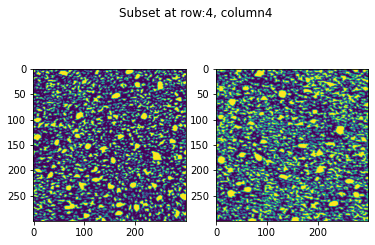

In [50]:
import cv2


#settings for heaviside pass
roi_disc = dict(size_pass = 300, overlap_percentage = 70, xcf_mesh=250)
dic_disc = DIC(images_corrected, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=0, col=0, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets
    
# Select a subset, here at row 20, column 20

subsets = get_subsets(images_corrected,4, 4, roi_disc)



In [12]:
from numba import double, jit

C:\Users\ab12215\AppData\Local\Continuum\anaconda3\envs\xpy\lib\site-packages\numba\core\ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'line' of function 'subset_hsfilter'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-48-73b94086f0fa>", line 31:
@jit(nopython=True)
def subset_hsfilter(imarray, line):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


22.4 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


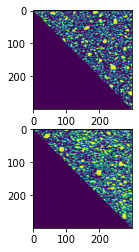

In [48]:


# Apply a line and step function



def gen_line(xc,yc,theta):
    
    line[0] = m
    line[1] = c
    return line

@jit(nopython=True)
def line_test(point, line):
    m = line[0]
    c = line[1]
    X = point[0]
    Y = point[1]
    yt = m*x+c
    Ax = X-10
    Ay = m*Ax+c
    Bx = X+10
    By = m*Bx+c
    position = np.sign((Bx - Ax) * (Y - Ay) - (By - Ay) * (X - Ax))
    if position == 0: # coincident
        return True
    elif position == -1:
        return False
    elif position == 1: 
        return True

@jit(nopython=True)
def subset_hsfilter(imarray, line):
    # rows and columns
    
    # preallocate
    hsfilter = np.zeros((imarray.shape[0],imarray.shape[0]))
    
    # placeholder line
    line = [1, 0]
    
    for y in range(imarray.shape[0]):
        for x in range(imarray.shape[0]):
            #rasters through columns and rows
            pixel = [x,y]
            if line_test(pixel, line):
                hsfilter[x,y] = 1
                
    hs_subset = np.zeros(imarray.shape)
    hs_subset[:,:,0] = np.multiply(hsfilter,imarray[:,:,0])
    hs_subset[:,:,1] = np.multiply(hsfilter,imarray[:,:,1])
    return hs_subset

ia = subsets

#fast_hsfilter  = jit(double[:,:](double[:,:], double[:,:]))

%timeit result = subset_hsfilter(ia,[0,1])

f, axarr = plt.subplots(2)
axarr[0].imshow(result[:,:,0])
axarr[1].imshow(result[:,:,1])

We now have to use a function to identify discontinuities

In [ ]:


def hs_optimisation(imarray):
    # minimise to obtain an initial guess
    
    
    # define initial guess
    line = [1,0] #m and c of line
    # define bounds of line
    ub = []
    lb = []
    
    
    # Parameters to minimise:
    # -angle of parallel line to  centre
    # -distance from centre
    
    # newton-raphson to obtain final location
    
    while acc>1e-8 and iter<50:
        # filter subsets
        
        fil_subs = subset_hsfilter(imarray, line)
        
        # cross correlate
        
        dx, dy, ph = crosspy.subset_compare(fil_subs)
        
        # error function
        
        resid = 0
        
        # convergence criteria
        
        
        
        
    
    

## Fine pass

Running sequential DIC on image pair 1 of 1 ...
... Completed in (s) 9338.238300085068


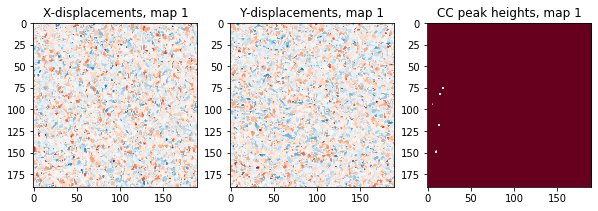

Calculating strain on map 1 of 1 ...
... Completed in (s) 27.462647914886475
Quick plotting strains


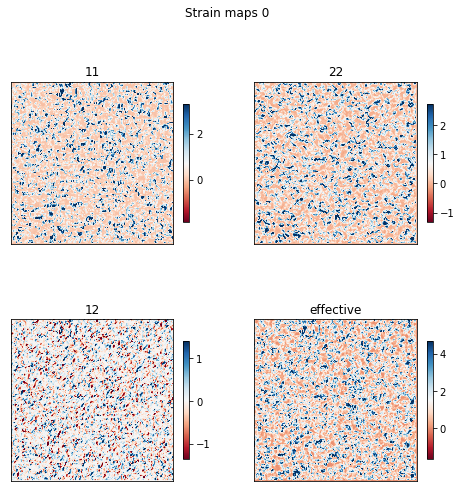

In [15]:
roi_2ndpass = dict(size_pass = 100, overlap_percentage = 90, xcf_mesh=250)
dic_2ndpass = DIC(images_corrected,roi_2ndpass,filter_settings)

# # run the second pass
dic_2ndpass.run_sequential()
dic_2ndpass.plot_displacements()

dic_2ndpass.calculate_strain(strain_method='l2')
dic_2ndpass.plot_strains()

Quick plotting strains


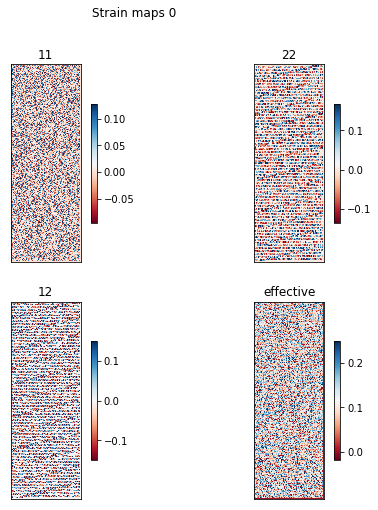

In [31]:
# # strain calc

dic_2ndpass.plot_strains()

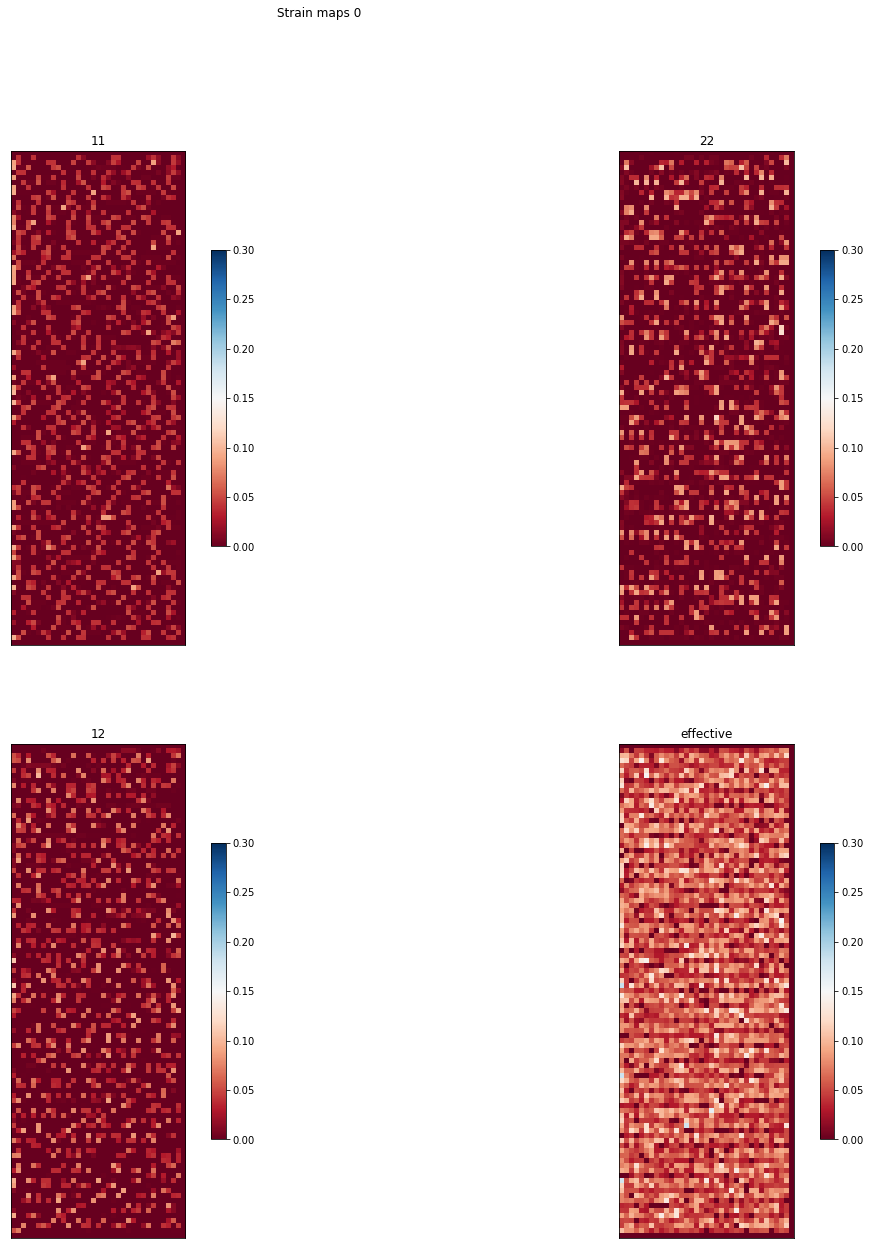

In [29]:
def plot_4(d, num, cmap):

    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    fig.suptitle('Strain maps '+str(num))
    Nr = 2
    Nc = 2
    images = []
    data = [d.strain_11[:,:,num], d.strain_22[:,:,num], d.strain_12[:,:,num], d.strain_eff[:,:,num]]
    names = ["11", "22", "12", "effective"]
    no = 0
    for i in range(Nr):
        for j in range(Nc):
            vmin = np.mean(data[no].flatten()) - 1*np.std(data[no].flatten())
            vmax = np.mean(data[no].flatten()) + 1*np.std(data[no].flatten())
            images.append(axs[i, j].imshow(data[no], cmap=cmap, vmin=0, vmax=0.3))
            axs[i, j].set_title(names[no])
            axs[i, j].label_outer()
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            fig.colorbar(images[no], ax=axs[i,j], shrink=0.6)
            no += 1
    plt.show()
    
    
    return fig, axs

fig, axs = plot_4(dic_2ndpass, 0, 'RdBu')

fig.savefig('STRAINS_'+str(roi_2ndpass['size_pass'])+'_'+str(roi_2ndpass['overlap_percentage']), dpi=400)